
# <span style="color:red">@@@@@@@@@@@@@Ayad@@@@@@@@@@@@@</span>

# <span style="color:blue">1.3 Take a look at data and prepare it</span>

In [1]:
import pandas as pd


SMSs = pd.read_table( r'D:\Projects\NLP\SMS classification\SMSs.tsv',
                        names=['label', 'message']
                        )


SMSs.shape

(5572, 2)

In [2]:
SMSs.head(10)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [3]:
SMSs.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [4]:
# convert the label to a numerical variable
SMSs['label_num'] = SMSs.label.map({'ham':0, 'spam':1})

# check that the conversion worked
SMSs.head(10)

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
6,ham,Even my brother is not like to speak with me. ...,0
7,ham,As per your request 'Melle Melle (Oru Minnamin...,0
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1


In [5]:
X = SMSs.message
y = SMSs.label_num
print(X.shape)
print(y.shape)

(5572,)
(5572,)


C:\Users\__Ayad__\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label_num', ylabel='count'>

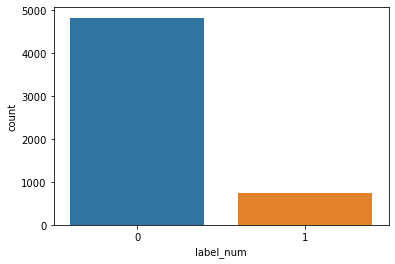

In [6]:
import seaborn as sns

sns.countplot(y)


### <span style="color:red">we infered that there is imbalance in Dataset</span>

In [7]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(4179,)
(4179,)
(1393,)
(1393,)


# <span style="color:blue">2.3 Sparse Matrix (document-term matrix)</span>

In [8]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words = stopwords.words('english'))

In [9]:
sparse_matrix = vectorizer.fit_transform(X_train)

In [10]:
sparse_matrix = pd.DataFrame(sparse_matrix.toarray(), columns=vectorizer.get_feature_names())

sparse_matrix.shape

(4179, 7325)

# <span style="color:blue">3.3 Traning and Evaluation</span>

## Evaluation on training data

In [11]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [12]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(nb, sparse_matrix, y_train, cv=7, verbose=1)
scores.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    5.1s finished


0.9767887054319215

In [13]:
# train the model using X_train
nb.fit(sparse_matrix, y_train)

y_pred = nb.predict(sparse_matrix)

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score


def evaluate(y_train, y_pred):
    print( 'Accuracy: ', accuracy_score(y_train, y_pred), '\n'*2+'='*60)
    print( 'Confusion Matrix:\n', confusion_matrix(y_train, y_pred), '\n'*2+'='*60)
    print( classification_report(y_train, y_pred))

In [15]:
evaluate(y_train, y_pred)

Accuracy:  0.9930605407992342 

Confusion Matrix:
 [[3600   17]
 [  12  550]] 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3617
           1       0.97      0.98      0.97       562

    accuracy                           0.99      4179
   macro avg       0.98      0.99      0.99      4179
weighted avg       0.99      0.99      0.99      4179



In [16]:
y_pred_prob = nb.predict_proba(sparse_matrix)
y_pred_prob.shape

(4179, 2)

In [17]:
roc_auc_score(y_train, y_pred_prob[:,1])

0.9955075724854066

In [18]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_pred_prob[:,1])

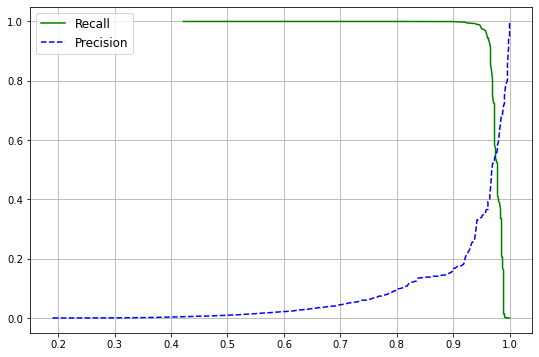

In [19]:
import matplotlib.pyplot as plt


plt.subplots(figsize=(9,6))


plt.plot(recalls[:-1], thresholds, "g-", label="Recall")
plt.plot(precisions[:-1], thresholds, "b--", label="Precision")


plt.grid()
plt.legend(prop={'size':12})
plt.show()

In [20]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob[:,1])

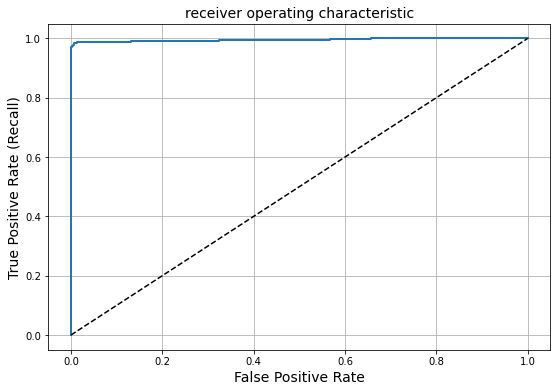

In [21]:
plt.subplots(figsize=(9,6))

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal

plt.title('receiver operating characteristic', size=14)
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate (Recall)', size=14)

plt.grid()
plt.show()

## pipeline building and evaluation on testing data

In [22]:
from sklearn.pipeline import Pipeline

process_and_predict = Pipeline([
                                ('vectorizer', vectorizer),
                                ('clf', nb)
                                 ])

In [23]:
y_pred_ = process_and_predict.predict(X_test)

In [24]:
evaluate(y_test, y_pred_)

Accuracy:  0.9899497487437185 

Confusion Matrix:
 [[1201    7]
 [   7  178]] 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1208
           1       0.96      0.96      0.96       185

    accuracy                           0.99      1393
   macro avg       0.98      0.98      0.98      1393
weighted avg       0.99      0.99      0.99      1393



In [25]:
y_pred_prob_ = process_and_predict.predict_proba(X_test)
y_pred_prob_.shape

(1393, 2)

In [26]:
roc_auc_score(y_test, y_pred_prob_[:,1])

0.9904510470735637

In [27]:
def HamOrSpam(message):
    pred = process_and_predict.predict([message])[0]
    if pred==0:
        print('This SMS is Spam')
    else:
        print('This SMS is Ham')
    

In [28]:
HamOrSpam("Hope you enjoyed your new content.")
HamOrSpam("K k:) sms chat with me")

This SMS is Spam
This SMS is Ham


### <span style="color:blue">Thank you, Guy ^_^</span>

# <span style="color:red">@@@@@@@@@@@@@Ayad@@@@@@@@@@@@@</span>